# Sequence To Sequence
- 인코더와 디코더로 구성된 모형
- 입력 시퀀스를 받아 출력 시퀀스를 생성하는 딥러닝 모델 구조
- 자연어 처리(NLP) 및 기타 시퀀스 데이터 처리에서 자주 사용
- 입력 길이와 출력 길이가 다른 경우 활용 (ex : 번역기, 텍스트 요약 등)


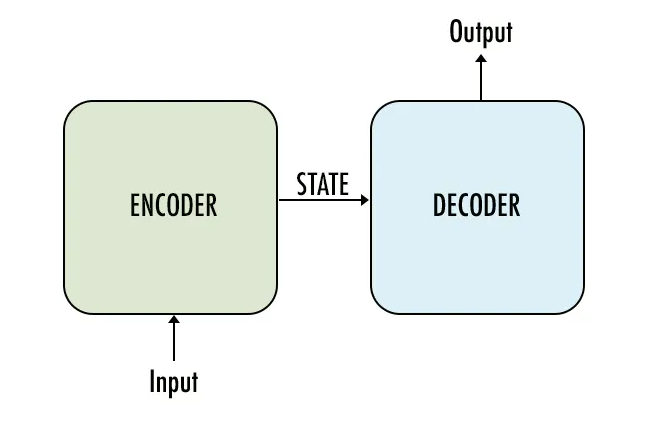

# seq2seq 구조
- 인코더(Encoder)와 디코더(Decoder)라는 모듈로 구성되어 “Encoder-Decoder 모델”이라고도 함

## Encoder
- 입력 시퀀스를 받아 고정된 크기의 벡터(컨텍스트 벡터, context vector)로 변환
- 일반적으로 순환 신경망(RNN), LSTM(Long Short-Term Memory), GRU(Gated Recurrent Unit)을 사용
- 입력 시퀀스의 각 요소를 처리하며 중요한 정보를 축적하여 최종적으로 요약된 벡터를 생성

## Decoder
- 인코더가 생성한 컨텍스트 벡터를 입력으로 받아 출력 시퀀스를 생성
- 디코더 역시 RNN, LSTM, GRU 등을 기반으로 하며, 이전에 생성된 출력 단어를 입력으로 받아 다음 단어를 예측
- 일반적으로 디코더는 순차적으로 출력 시퀀스를 생성

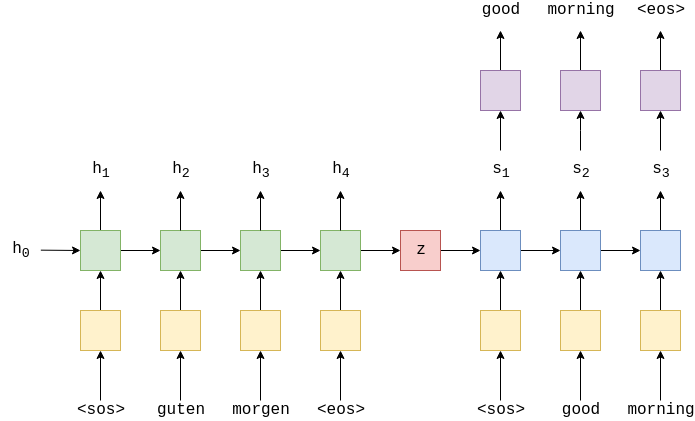

# 작동 원리

## Encoder 단계
1. 매 시점 원문의 단어가 입력되면 인코더는 이를 이용해 은닉 상태를 업데이트
3. 입력 시퀀스의 끝까지 이 과정을 반복하면 인코더의 최종 은닉 상태는 입력 시퀀스의 정보를 압축 요약한 정보를 담고 있게 됨
4. 이 마지막 시점에서의 인코더 은닉 상태를 컨텍스트 벡터라고 하고, 이 값은 디코더로 넘어감

## Decoder
1. 디코더는 전달받은 컨텍스트 벡터로 자신의 은닉 상태를 초기화
2. 그리고 매 시점 자신이 바로 직전 시점에 출력했던 단어를 입력으로 받아, 자신의 은닉 상태를 업데이트하고, 이를 이용해 다음 단어를 예측
    - 최초 시점에서는 시퀀스 시작을 의미하는 `<sos>` 토큰(Start Of Sequence)을 입력으로 받는다.
3. 이 과정을 정해진 반복 횟수 또는 시퀀스 끝을 나타내는 `<eos>` 토큰(End Of Sequence)이 나올 때까지 수행

# 주요 특징
- 시퀀스 길이의 유연성
> 입력 시퀀스와 출력 시퀀스의 길이가 달라도 처리할 수 있음
- 학습 방법
> 일반적으로 교사 강요(Teacher Forcing)를 사용해 디코더가 학습 과정에서 정답 단어를 참조할 수 있도록 함

# 영한 번역 데이터셋
- https://drive.google.com/file/d/1xDgkyWLxHiBBBSXI_kG7M1JNEM3sHKiA/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = "/content/drive/MyDrive/ms_3rd/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
class Vocab:
    def __init__(self, tokens_list, specials = [], unk_token = None):
        self.id2token = set()
        for tokens in tokens_list:
            self.id2token.update(tokens)
        self.id2token = specials + sorted(list(self.id2token))
        self.token2id = { t:i for i, t in enumerate(self.id2token)  }
        self.unk_token = unk_token
    def __len__(self):
        return len(self.id2token)

    def __call__(self, tokens):
        return [
            self.token2id[t] if self.token2id.get(t) is not None else self.token2id[self.unk_token]
            for t in tokens
        ]

# 한국어 to 영어

In [3]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 74.3 MB/s eta 0:00:00
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.20.0-py3-none-any.whl size=34818026 sha256=6d893a1b4105e24fb451d7ebc31da4fadc32a38966d2367b37c50c182cb39a13
  Stored in directory: /root/.cache/pip/wheels/b6/b1/66/2be9840f8ef3627d63d93503d81a5e3b41e9498dcb63b00b13
Successfully built kiwipiepy-model


In [22]:
train = pd.read_csv(f"{DATA_PATH}translate_en_ko.csv")
train.shape

(5794, 2)

In [23]:
train.head()

,en,ko
0,These products are of the same quality.,이 제품들은 같은 품질이다.
1,The meeting was cancelled.,미팅이 취소되었다.
2,They found this.,그들이 이것을 찾았다.
3,Tom didn't tell Mary why he had to work late.,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.
4,After you.,먼저 가세요.


# 데이터 정제

In [24]:
train["ko"] = train["ko"].str.replace("[^가-힣0-9,.!? ]", "", regex=True)

In [25]:
train["en"] = train["en"].str.replace("[^a-zA-Z0-9,.!? ]", "", regex=True)

# 한국어 전처리

## 토큰화

In [26]:
from kiwipiepy import Kiwi

kiwi = Kiwi()

In [29]:
src_data = []
for tokens in kiwi.tokenize(train["ko"]):
    tokens = [t.form for t in tokens]
    src_data.append(tokens)

## 어휘집 생성

In [31]:
vocab_ko = Vocab(src_data, ["<pad>", "<unk>"], "<unk>")
len(vocab_ko)

3251

## 단어 번호 부여

In [35]:
src_data = [vocab_ko(tokens) for tokens in src_data]

In [37]:
src_data[0]

[2281, 2572, 889, 2238, 143, 2238, 3054, 2281, 701, 4]

# 영어 전처리

## 토큰화

In [41]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [65]:
sos_token = "<sos>"
eos_token = "<eos>"
trg_data = []
for text in train["en"]:
    tokens = [sos_token] + word_tokenize(text) + [eos_token]
    trg_data.append(tokens)

In [66]:
trg_data[4]

['<sos>', 'After', 'you', '.', '<eos>']

## 어휘집 생성

In [67]:
vocab_en = Vocab(trg_data, ["<pad>", "<unk>"], "<unk>")
len(vocab_en)

3524

In [68]:
vocab_en.token2id["<sos>"], vocab_en.token2id["<eos>"]

(33, 32)

## 단어 번호 부여

In [69]:
trg_data = [vocab_en(tokens) for tokens in trg_data]

In [70]:
trg_data[4]

[33, 44, 3511, 4, 32]

# 데이터셋 클래스

In [75]:
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, src, trg):
        self.src, self.trg = src, trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, i):
        return {
            "src": torch.tensor(self.src[i]),
            "trg": torch.tensor(self.trg[i])
        }

In [78]:
dataset = TranslationDataset(src_data, trg_data)
dataset[0]

{'src': tensor([2281, 2572,  889, 2238,  143, 2238, 3054, 2281,  701,    4]),
 'trg': tensor([  33,  531, 2553,  741, 2328, 3159, 2749, 2582,    4,   32])}

## torch.nn.utils.rnn.pad_sequence 함수
- sequences: int64(단어 번호)로 이루어진 1차원 텐서들을 담고 있는 리스트 전달
    - 리스트 내 최대 길이의 텐서에 맞게 패딩
- batch_first: True 전달(기본값 False)

In [83]:
x = [torch.tensor(tokens) for tokens in src_data[:4]]
torch.nn.utils.rnn.pad_sequence(x, batch_first=True)

tensor([[2281, 2572,  889, 2238,  143, 2238, 3054, 2281,  701,    4,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [1202, 2281, 2850,  854, 1997,  701,    4,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 396,  889, 2281, 2283, 2244, 2764, 1997,  701,    4,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [2960, 2238, 1099, 2001, 2120,  396,   77,  695,  206,  497, 2361, 3072,
         1959, 3072, 1997,  691, 1890, 1935, 2613, 2659, 1884, 1997,  701,    4]])

## DataLoader 클래스의 collate_fn 파라미터
- 배치 단위로 데이터를 처리하는 콜백 함수를 전달

In [99]:
def collate_fn(batch_data):
    src = [data["src"] for data in batch_data]
    trg = [data["trg"] for data in batch_data]

    src = torch.nn.utils.rnn.pad_sequence(src, batch_first=True)
    trg = torch.nn.utils.rnn.pad_sequence(trg, batch_first=True)

    return {"src": src, "trg": trg}

In [101]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn)
batch = next(iter(dataloader))
batch

{'src': tensor([[2281, 2572,  889, 2238,  143, 2238, 3054, 2281,  701,    4],
         [1202, 2281, 2850,  854, 1997,  701,    4,    0,    0,    0]]),
 'trg': tensor([[  33,  531, 2553,  741, 2328, 3159, 2749, 2582,    4,   32],
         [  33,  527, 2167, 3378,  995,    4,   32,    0,    0,    0]])}

# Encoder 만들기

In [102]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(vocab_size, emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim, emb_dim * 2, batch_first=True, bidirectional=True)

    def forward(self, x): # src 텐서 전달
        x = self.emb_layer(x) # batch, seq, feature
        _, (hn, cn) =  self.lstm(x)
        return hn, cn

# Decoder

# Seq2Seq 모델